In [127]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, pacf
from statsmodels.tsa.stattools import acf, q_stat, adfuller
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import probplot, moment
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime 
from pathlib import Path

import plotly.express as px
import my_utilities
import custom_functions as cf

cfg = my_utilities.__cfg_reading()

KPI_LIST = ['adCost','clicksCounter','impressionsCounter']
PROJECT_PATH = eval(cfg['PROJECT_PATH'])
DATA_PATH = PROJECT_PATH/cfg['DATA_FOLDER']
FILE = cfg['FILE_TO_EXPLORE']
OUTPUT_FILE = cfg['OUTPUT_FILE']

In [128]:
amazon = pd.read_csv('AMAZON_CLEANED.csv')
amazon.sort_values(by='calDate', inplace=True, ignore_index=True)
fb = pd.read_csv('FACEBOOK_CLEANED.csv')
fb.sort_values(by='calDate', inplace=True)
google = pd.read_csv('GOOGLE_CLEANED.csv')
google.sort_values(by='calDate', inplace=True)
revenues = pd.read_csv('inputs/revenuesTest.csv')
revenues.sort_values(by='calDate', inplace=True)

amazon['calDate'] = pd.to_datetime(amazon['calDate']).dt.date
fb['calDate'] = pd.to_datetime(fb['calDate']).dt.date
google['calDate'] = pd.to_datetime(google['calDate']).dt.date
revenues['calDate'] = pd.to_datetime(revenues['calDate']).dt.date


print(f"AMAZON records: {len(amazon)}")
print(f"FACEBOOK records: {len(fb)}")
print(f"GOOGLE records: {len(google)}")
print(f"REVENUES records: {len(revenues)}")

AMAZON records: 101
FACEBOOK records: 1164
GOOGLE records: 561
REVENUES records: 3186


Ci sono duplicati?

In [129]:
assert len(amazon) == len(amazon.drop_duplicates()), "Amazon KO"
assert len(google) == len(google.drop_duplicates()), "Google KO"
assert len(fb) == len(fb.drop_duplicates()), "Facebook KO"
assert len(revenues) == len(revenues.drop_duplicates()), "Revenues KO"

AssertionError: Revenues KO

In [130]:
revenues = revenues.drop_duplicates().reset_index(drop=True)
assert len(revenues) == len(revenues.drop_duplicates()), "Revenues KO"
revenues.groupby('calDate')['totDailyGrossRevenue'].sum()

calDate
2018-08-26      32.00
2018-08-27       0.00
2018-08-28       0.00
2018-08-29       0.00
2018-08-30       0.00
               ...   
2023-02-09    8641.16
2023-02-10    7177.02
2023-02-11    6076.27
2023-02-12    6763.88
2023-02-13    4556.74
Name: totDailyGrossRevenue, Length: 1633, dtype: float64

# HISTORICAL DEPTH

In [132]:
print(f"Start Date: {amazon['calDate'].min()}, End Date: {amazon['calDate'].max()}")
print(f"Start Date: {fb['calDate'].min()}, End Date: {fb['calDate'].max()}")
print(f"Start Date: {google['calDate'].min()}, End Date: {google['calDate'].max()}")
print(f"Start Date: {revenues['calDate'].min()}, End Date: {revenues['calDate'].max()}")

min_date = min([amazon['calDate'].min(),fb['calDate'].min(),google['calDate'].min()])


Start Date: 2022-10-22, End Date: 2023-02-20
Start Date: 2019-03-03, End Date: 2023-01-05
Start Date: 2021-08-02, End Date: 2023-02-14
Start Date: 2018-08-26, End Date: 2023-02-13


Ci sono delle revenues precedenti alla prima data di partenza delle prime campagne...errore? Andiamo ad analizzare quei dati

In [133]:
revenues_out = revenues[revenues['calDate']<min_date]
revenues_out.head(5)

,calDate,connectionStream,totDailyGrossRevenue
0,2018-08-26,1.amazon_seller,32.0
1,2018-08-27,1.amazon_seller,0.0
2,2018-08-28,1.amazon_seller,0.0
3,2018-08-29,1.amazon_seller,0.0
4,2018-08-30,1.amazon_seller,0.0


In [134]:
fig = px.line(revenues_out, x="calDate", y="totDailyGrossRevenue", color='connectionStream', title="Revenues over Time")
fig.show()
revenues_out['cumsum_totDailyGrossRevenue'] = revenues_out.groupby('connectionStream')['totDailyGrossRevenue'].cumsum().round(0)
#cumulative
fig = px.line(revenues_out, x="calDate", y="cumsum_totDailyGrossRevenue", color='connectionStream', title="Cumulative Revenues")
fig.show()

Sembrano trascurabili, quanto pesano sul totale?

In [135]:
print(revenues_out['totDailyGrossRevenue'].sum()/revenues['totDailyGrossRevenue'].sum())

0.000517594463032965


Sono c.ca 5 basis point, rimuovo

In [136]:
revenues = revenues[revenues['calDate']>=min_date].reset_index(drop=True)
revenues.head()

,calDate,connectionStream,totDailyGrossRevenue
0,2019-03-03,1.woocommerce,124.06
1,2019-03-03,1.amazon_seller,0.00
2,2019-03-04,1.amazon_seller,0.00
3,2019-03-04,1.woocommerce,88.97
4,2019-03-05,1.woocommerce,0.00


In [137]:
revenues = revenues.groupby('calDate')['totDailyGrossRevenue'].sum().reset_index()

In [138]:
revenues['calDate'] = pd.to_datetime(revenues['calDate'])
google['calDate'] = pd.to_datetime(google['calDate'])
amazon['calDate'] = pd.to_datetime(amazon['calDate'])
fb['calDate'] = pd.to_datetime(fb['calDate'])

In [139]:
df_final = pd.merge(revenues, google, on='calDate', how='left', suffixes=[None,'GOOG'])
print(df_final.columns)
df_final = pd.merge(df_final, fb, on='calDate', how='left',suffixes=[None,'FB'])
df_final = pd.merge(df_final, amazon, on='calDate', how='left',suffixes=[None,'AMZ'])

df_final

Index(['calDate', 'totDailyGrossRevenue', 'adCost', 'clicksCounter',
       'impressionsCounter'],
      dtype='object')


,calDate,totDailyGrossRevenue,adCost,clicksCounter,impressionsCounter,adCostFB,clicksCounterFB,impressionsCounterFB,adCostAMZ,clicksCounterAMZ,impressionsCounterAMZ
0,2019-03-03,124.06,NaN,NaN,NaN,19.60,171.0,10201.0,NaN,NaN,NaN
1,2019-03-04,88.97,NaN,NaN,NaN,20.09,160.0,10806.0,NaN,NaN,NaN
2,2019-03-05,0.00,NaN,NaN,NaN,17.44,145.0,8023.0,NaN,NaN,NaN
3,2019-03-06,53.52,NaN,NaN,NaN,19.54,158.0,10395.0,NaN,NaN,NaN
4,2019-03-07,0.00,NaN,NaN,NaN,1.10,11.0,565.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
1439,2023-02-09,8641.16,10.68,29.0,122.0,NaN,NaN,NaN,690.36,977.0,164195.0
1440,2023-02-10,7177.02,8.06,22.0,92.0,NaN,NaN,NaN,840.29,1222.0,209615.0
1441,2023-02-11,6076.27,8.92,13.0,72.0,NaN,NaN,NaN,774.07,1147.0,191259.0
1442,2023-02-12,6763.88,5.72,17.0,66.0,NaN,NaN,NaN,897.04,1341.0,227714.0


In [140]:
df_final['adCost'].count()

560

[1, 2, 3, 4, 5, 7, 11, 12, 14, 16, 17, 19, 20, 21, 26, 27, 28, 29]


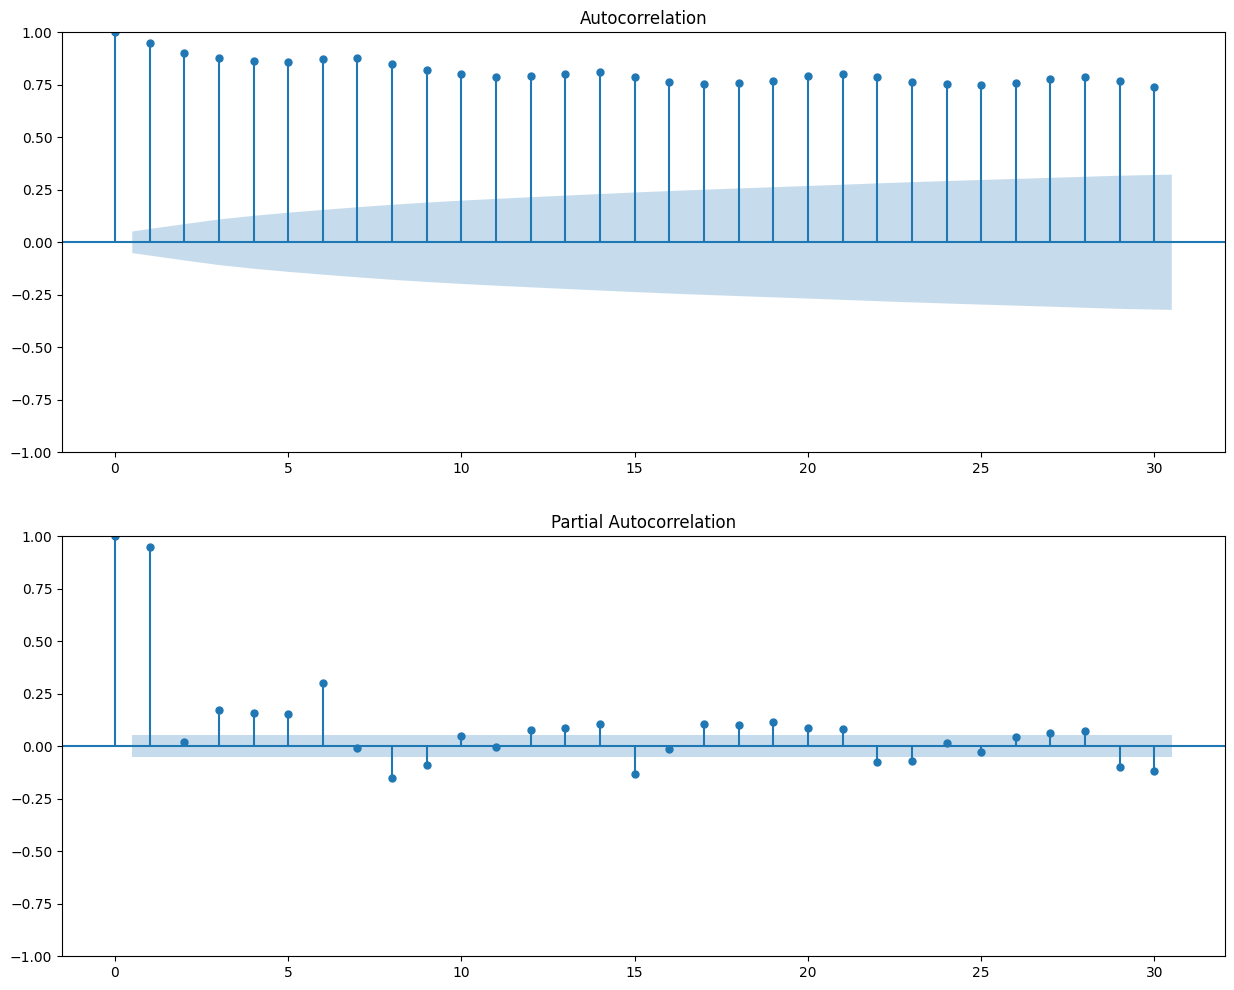

In [141]:
def get_relevant_lag(data,  target='adCost', n_lags=12):
    
    data_ = data[target].copy()
    
    # Calcolo PACF
    lag, ci = pacf(data_, nlags=n_lags, alpha=0.05)
    
    # Calcolo il limite (area blu in grafico pacf)
    boundaries = np.abs(np.array([ci - lag for lag, ci in zip(lag, ci)])[:, 1])
    
    # estraggo i lags maggiori dei limiti
    imp_lags = np.where(np.abs(lag) > boundaries)[0]
    
    imp_lags = list(set(imp_lags) - set([0]))
    
    return imp_lags

df_final = df_final.fillna(0)
# generate ACF and PACF plots
fig, ax = plt.subplots(2, figsize=(15,12))
plot_acf(df_final['totDailyGrossRevenue'], ax=ax[0], lags=30)
plot_pacf(df_final['totDailyGrossRevenue'], ax=ax[1], lags=30)
print(get_relevant_lag(df_final, target='adCost', n_lags=30))
plt.show()

In [166]:
df_cp = df_final.copy()
df_cp = df_cp.set_index('calDate')

dict_ts = cf.decompose_time_series(df_cp['adCost'])

KeyError: 'adCost'

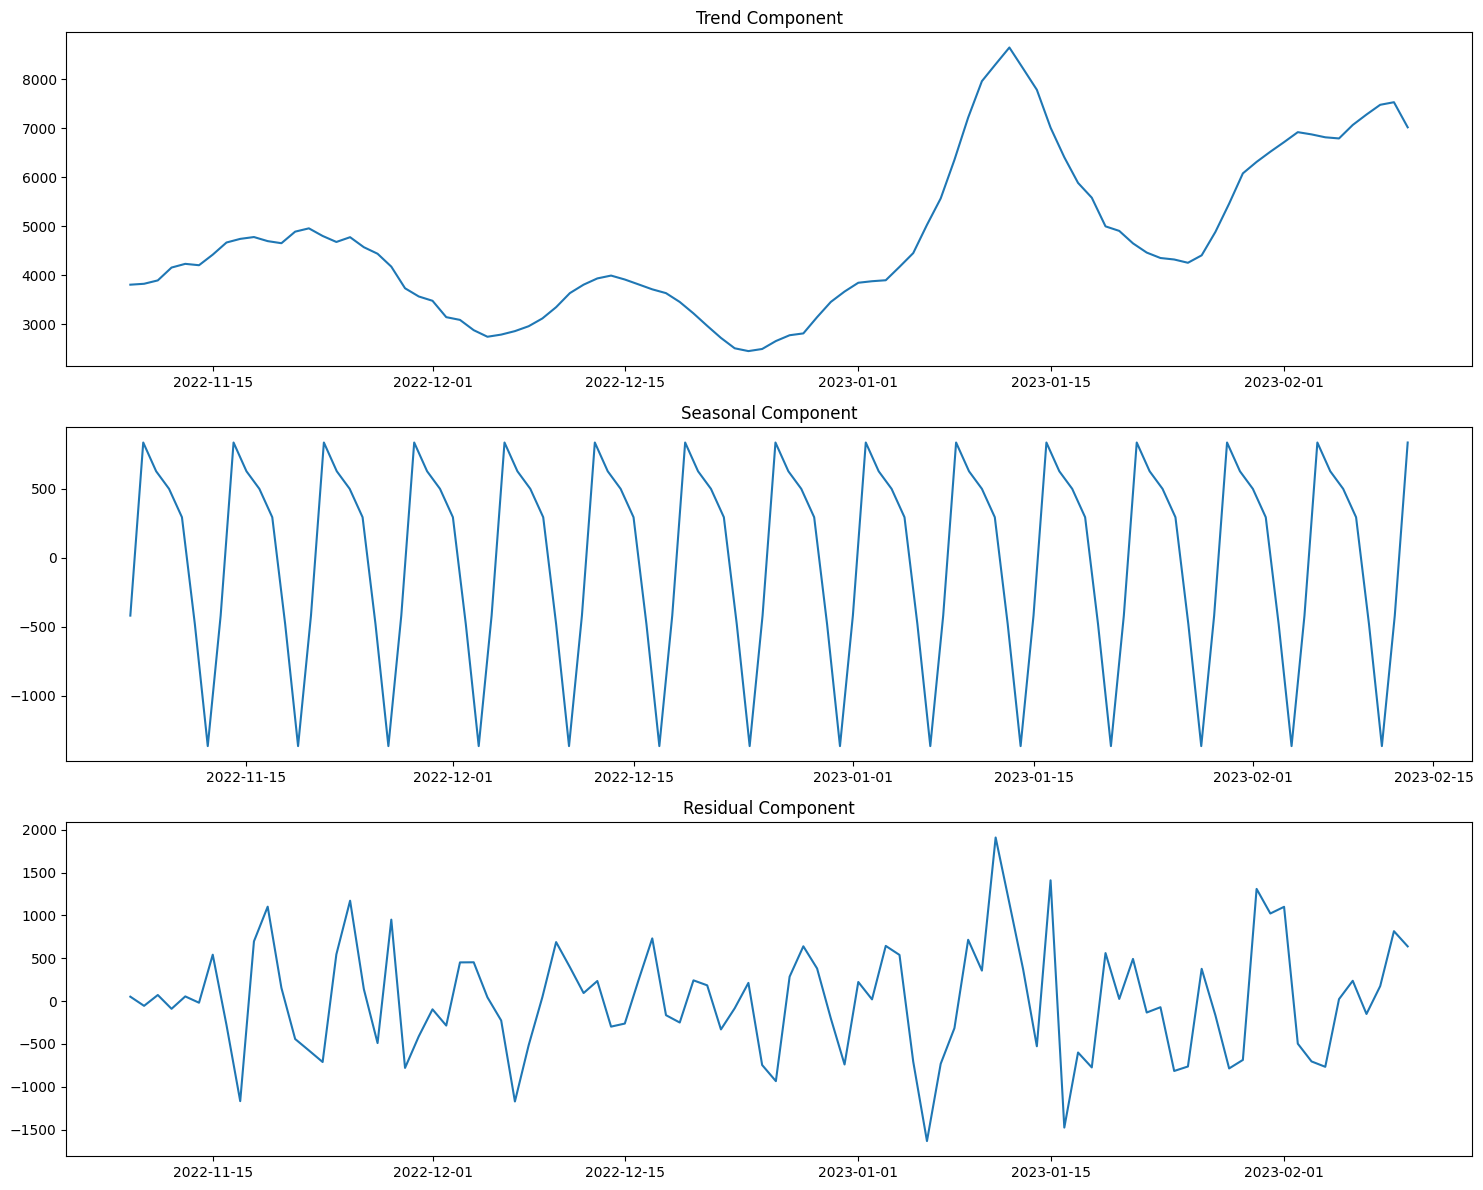

In [167]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

# Load data
df = df_cp

# Perform seasonal decomposition
decomposed = seasonal_decompose(df_cp['totDailyGrossRevenue'][-100:], model='additive', period=7)

trend = decomposed.trend
seasonal = decomposed.seasonal
residual = decomposed.resid


fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(15,12))
axes[0].plot(trend)
axes[0].set_title("Trend Component")
axes[1].plot(seasonal)
axes[1].set_title("Seasonal Component")
axes[2].plot(residual)
axes[2].set_title("Residual Component")
plt.tight_layout()
plt.show()

In [168]:
df_final['totalcost'] = df_final['adCost'] + df_final['adCostFB'] + df_final['adCostAMZ'] 
df_final.columns = ["calDate","totDailyGrossRevenue","adCostGOG", "clicksCounterGOG", "impressionsCounterGOG", "adCostFB", "clicksCounterFB", "impressionsCounterFB", "adCostAMZ", "clicksCounterAMZ", "impressionsCounterAMZ","totalcost"]
df_final.head()

KeyError: 'adCost'

In [ ]:
fig = px.line(df_final[-100:], x="calDate", y=["totDailyGrossRevenue", 'totalcost'],  title="Revenues over Time")
fig.update_layout(
    autosize=False,
    width=1600,
    height=800,)
fig.show()
#cumulative

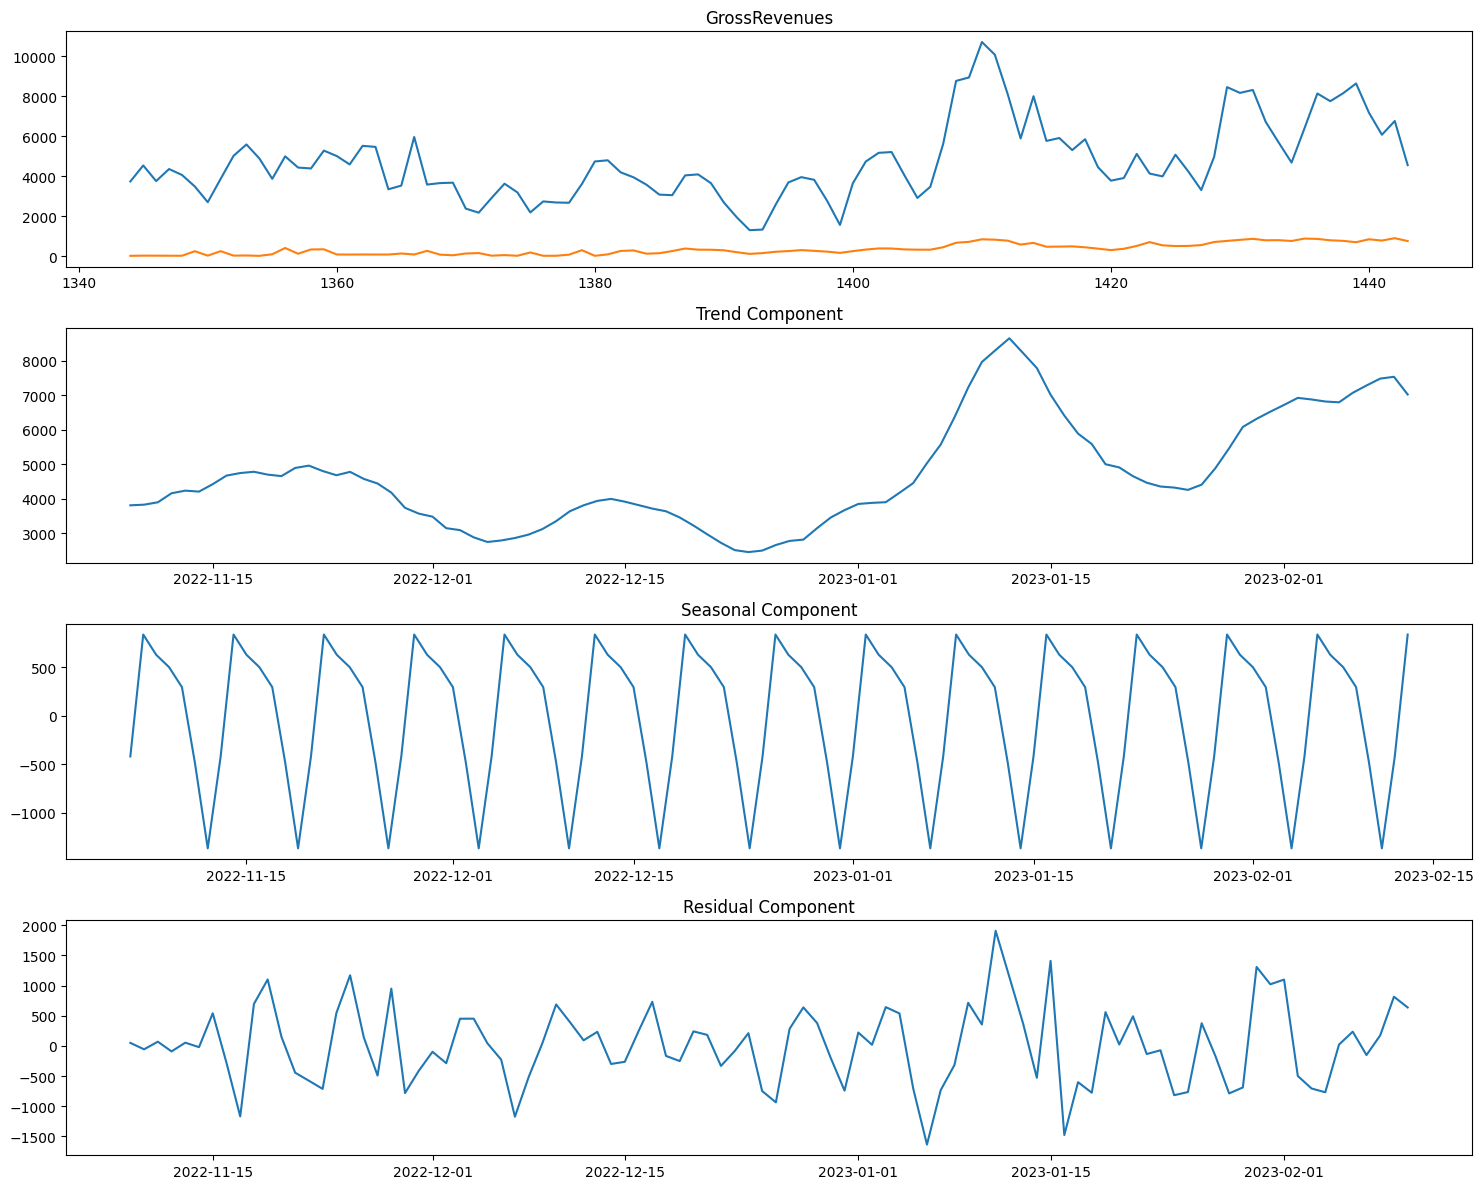

In [ ]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

# Load data
df = df_cp

# Perform seasonal decomposition
decomposed = seasonal_decompose(df_cp['totDailyGrossRevenue'][-100:], model='additive', period=7)

trend = decomposed.trend
seasonal = decomposed.seasonal
residual = decomposed.resid


fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(15,12))
axes[0].plot(df_final['totDailyGrossRevenue'][-100:])
axes[0].plot(df_final['totalcost'][-100:])

axes[0].set_title("GrossRevenues")
axes[1].plot(trend)
axes[1].set_title("Trend Component")
axes[2].plot(seasonal)
axes[2].set_title("Seasonal Component")
axes[3].plot(residual)
axes[3].set_title("Residual Component")
plt.tight_layout()
plt.show()

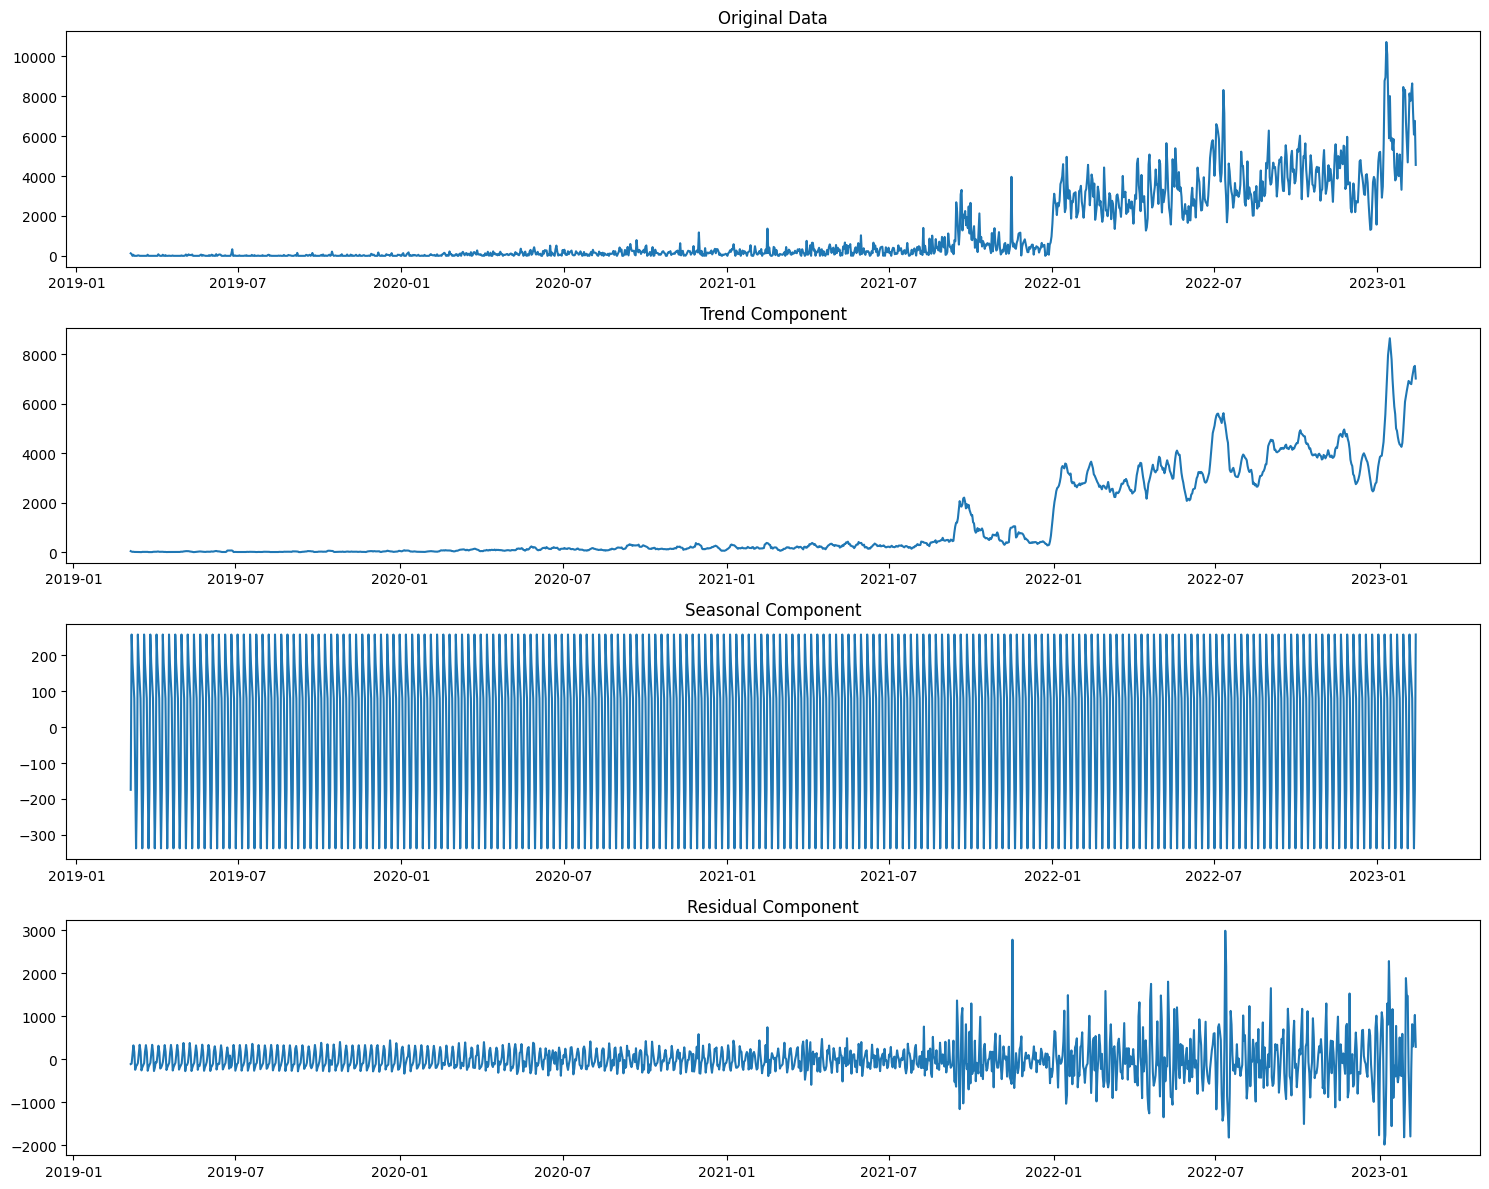

In [158]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose


#test = df_cp.copy()['totDailyGrossRevenue'][-300:]
# perform seasonal decomposition
result = seasonal_decompose(df_cp['totDailyGrossRevenue'], model='additive', period=7)
#result = seasonal_decompose(test, model='additive', period=100)

# plot the decomposed components
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 12))
#ax1.plot(test)
ax1.plot(df_cp['totDailyGrossRevenue'])
ax1.set_title('Original Data')
ax2.plot(result.trend)
ax2.set_title('Trend Component')
ax3.plot(result.seasonal)
ax3.set_title('Seasonal Component')
ax4.plot(result.resid)
ax4.set_title('Residual Component')
plt.tight_layout()
plt.show()


In [159]:
df_final

,calDate,totDailyGrossRevenue,adCostGOG,clicksCounterGOG,impressionsCounterGOG,adCostFB,clicksCounterFB,impressionsCounterFB,adCostAMZ,clicksCounterAMZ,...,rol_clicksCounterGOG_7d,rol_impressionsCounterGOG_7d,rol_adCostFB_7d,rol_clicksCounterFB_7d,rol_impressionsCounterFB_7d,rol_adCostAMZ_7d,rol_clicksCounterAMZ_7d,rol_impressionsCounterAMZ_7d,seasonal,trend
0,2019-03-03,124.06,0.00,0.0,0.0,19.60,171.0,10201.0,0.00,0.0,...,0.000000,0.000000,19.600000,171.000000,10201.000000,0.000000,0.000000,0.000000,-174.499271,0.000000
1,2019-03-04,88.97,0.00,0.0,0.0,20.09,160.0,10806.0,0.00,0.0,...,0.000000,0.000000,19.845000,165.500000,10503.500000,0.000000,0.000000,0.000000,257.715552,0.000000
2,2019-03-05,0.00,0.00,0.0,0.0,17.44,145.0,8023.0,0.00,0.0,...,0.000000,0.000000,19.043333,158.666667,9676.666667,0.000000,0.000000,0.000000,178.161510,0.000000
3,2019-03-06,53.52,0.00,0.0,0.0,19.54,158.0,10395.0,0.00,0.0,...,0.000000,0.000000,19.167500,158.500000,9856.250000,0.000000,0.000000,0.000000,127.200760,38.078571
4,2019-03-07,0.00,0.00,0.0,0.0,1.10,11.0,565.0,0.00,0.0,...,0.000000,0.000000,15.554000,129.000000,7998.000000,0.000000,0.000000,0.000000,79.783433,20.355714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1439,2023-02-09,8641.16,10.68,29.0,122.0,0.00,0.0,0.0,690.36,977.0,...,21.714286,88.571429,0.000000,0.000000,0.000000,789.275714,1160.857143,247616.714286,79.783433,7529.782857
1440,2023-02-10,7177.02,8.06,22.0,92.0,0.00,0.0,0.0,840.29,1222.0,...,22.142857,93.857143,0.000000,0.000000,0.000000,795.708571,1164.857143,234795.857143,-130.921591,7017.914286
1441,2023-02-11,6076.27,8.92,13.0,72.0,0.00,0.0,0.0,774.07,1147.0,...,21.285714,96.714286,0.000000,0.000000,0.000000,797.974286,1175.000000,225732.285714,-337.440393,0.000000
1442,2023-02-12,6763.88,5.72,17.0,66.0,0.00,0.0,0.0,897.04,1341.0,...,20.571429,93.857143,0.000000,0.000000,0.000000,800.727143,1181.571429,213373.000000,-174.499271,0.000000


In [160]:
rol_cols = ['adCostGOG','clicksCounterGOG','impressionsCounterGOG','adCostFB','clicksCounterFB','impressionsCounterFB','adCostAMZ','clicksCounterAMZ','impressionsCounterAMZ']

for col in rol_cols:
    df_final['rol_'+col+'_7d'] = df_final[col].rolling(7, min_periods=1).mean()

In [161]:
df_final['seasonal'] = result.seasonal.reset_index(drop=True)
df_final['trend'] = result.trend.reset_index(drop=True).fillna(0)

feature_cols = [col for col in df_final.columns if col not in ['totDailyGrossRevenue','calDate']]
target = ['totDailyGrossRevenue']
print(feature_cols)
df_final_scaled = df_final.copy()

for feature in feature_cols:
    scaler = MinMaxScaler()
    original = df_final_scaled[feature].values.reshape(-1, 1)
    transformed = scaler.fit_transform(original)
    df_final_scaled[feature] = transformed

df_final_scaled['totDailyGrossRevenue'] = df_final_scaled['totDailyGrossRevenue']/1000
dt.dayofweek

['adCostGOG', 'clicksCounterGOG', 'impressionsCounterGOG', 'adCostFB', 'clicksCounterFB', 'impressionsCounterFB', 'adCostAMZ', 'clicksCounterAMZ', 'impressionsCounterAMZ', 'totalcost', 'rol_adCostGOG_7d', 'rol_clicksCounterGOG_7d', 'rol_impressionsCounterGOG_7d', 'rol_adCostFB_7d', 'rol_clicksCounterFB_7d', 'rol_impressionsCounterFB_7d', 'rol_adCostAMZ_7d', 'rol_clicksCounterAMZ_7d', 'rol_impressionsCounterAMZ_7d', 'seasonal', 'trend']


NameError: name 'dt' is not defined

In [162]:
import pandas as pd
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split

# Load the data into a Pandas DataFrame
#data = df_final.drop(columns=['totalcost','clicksCounter','impressionsCounter', 'clicksCounterFB','impressionsCounterFB','clicksCounterAMZ','impressionsCounterAMZ'])
#data = df_final.drop(columns=['totalcost','adCost','impressionsCounter', 'adCostFB','impressionsCounterFB','adCostAMZ','impressionsCounterAMZ'])
data = df_final_scaled.copy()
data.fillna(0, inplace=True)
cols = [el for el in data.columns if el not in ['totDailyGrossRevenue','calDate']]


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data[cols], data['totDailyGrossRevenue'], test_size=0.2, random_state=42)

# Fit a linear regression model to the training data
model =  Ridge(alpha=2).fit(X_train, y_train)

# Evaluate the model on the test data
r_squared = model.score(X_test, y_test)
coefficients = dict(zip(cols, model.coef_))

# Print the results
print(f'R-squared: {r_squared:.2f}')

for k,v in coefficients.items():
    print(k,v)

model.intercept_

y_pred = model.predict(X_test)

R-squared: 0.91
adCostGOG 0.07951309079943363
clicksCounterGOG 0.7045649788937103
impressionsCounterGOG -0.23130852186445588
adCostFB -0.10747133107067645
clicksCounterFB -0.16921318341238573
impressionsCounterFB -0.014957173844005897
adCostAMZ 0.9505206685175895
clicksCounterAMZ 0.922694907002296
impressionsCounterAMZ -0.4699136143618844
totalcost 0.5117246498632008
rol_adCostGOG_7d -0.08965189613678898
rol_clicksCounterGOG_7d 0.3466157236384539
rol_impressionsCounterGOG_7d -0.39832636307818337
rol_adCostFB_7d -0.20231643743985148
rol_clicksCounterFB_7d -0.2146644763162554
rol_impressionsCounterFB_7d -0.18552141462589275
rol_adCostAMZ_7d 0.3635773446612435
rol_clicksCounterAMZ_7d 0.2237457211110974
rol_impressionsCounterAMZ_7d -0.34684730812670905
seasonal 0.5515320466411818
trend 7.464606874631581


In [163]:
fig = px.line( y=[y_test,y_pred],  title="Revenues over Time")

fig.update_layout(
    autosize=False,
    width=1600,
    height=800,)

fig.for_each_trace(lambda t: t.update(name = {
        "wide_variable_0": "y_test", 
        "wide_variable_1": "y_pred"
        }[t.name]))

fig.show()


In [137]:
from sklearn.model_selection import cross_val_score, TimeSeriesSplit

#data = df_final.drop(columns=['totalcost','clicksCounter','impressionsCounter', 'clicksCounterFB','impressionsCounterFB','clicksCounterAMZ','impressionsCounterAMZ'])
#
data = df_final.drop(columns=['totalcost','impressionsCounter','adCost', 'impressionsCounterFB','adCostFB','impressionsCounterAMZ','adCostAMZ'])
data = data[data['calDate']>=pd.to_datetime('2022-01-01')]
#data = df_final.drop(columns=['totalcost','clicksCounter','adCost', 'clicksCounterFB','adCostFB','clicksCounterAMZ','adCostAMZ'])

data.fillna(0, inplace=True)
data.set_index('calDate',inplace=True)

X = data.drop(columns='totDailyGrossRevenue')
y = data['totDailyGrossRevenue']

lr = LinearRegression()

print(cross_val_score(lr, X, y, cv=TimeSeriesSplit()))

lr.fit(X, y) # refit the model with the complete dataset

print('Coefficients:', lr.coef_)
print('Intercept:', lr.intercept_)

[-0.90028993 -1.41805188 -0.66195629 -0.95855658  0.11630869]
Coefficients: [ 2.76063438 -0.44708441  2.85877324]
Intercept: 3268.9629106629445


In [134]:
tmp = df_final[df_final['calDate']>=pd.to_datetime('2022-01-01')]

print(f"FACEBOOK: {tmp['clicksCounterFB'].sum()/tmp['adCostFB'].sum()}")
print(f"GOOG: {tmp['clicksCounter'].sum()/tmp['adCost'].sum()}")
print(f"AMZ: {tmp['clicksCounterAMZ'].sum()/tmp['adCostAMZ'].sum()}")

FACEBOOK: 2.6702043145935694
GOOG: 4.019727815478177
AMZ: 1.626487376791674


In [135]:
tmp.sum()

totDailyGrossRevenue      1529467.12
adCost                       5123.73
clicksCounter               20596.00
impressionsCounter         130163.00
adCostFB                    18151.42
clicksCounterFB             48468.00
impressionsCounterFB      4009568.00
adCostAMZ                   33823.81
clicksCounterAMZ            55014.00
impressionsCounterAMZ    14043485.00
totalcost                   57098.96
dtype: float64

In [123]:
#data[['adCost','adCostFB','adCostAMZ','totDailyGrossRevenue']][-44:]
#data[['adCost','adCostFB','adCostAMZ','totDailyGrossRevenue']][:44]

fig = px.line(data, y=['adCost','adCostFB','adCostAMZ','totDailyGrossRevenue'],  title="Revenues over Time")
fig.update_layout(
    autosize=False,
    width=1600,
    height=800,)
fig.show()
#cumulative


In [ ]:
revenue = 3187.9985482328584 + 4.88793947*(google) + 2.45256553*(fb) + 4.61254024*(amz)

In [ ]:
import matplotlib.pyplot as plt

# Get the actual and predicted values
y_actual = test_df['totDailyGrossRevenue']
y_pred = test_pred['totDailyGrossRevenue']

# Plot the actual vs predicted values
plt.scatter(y_actual, y_pred)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.show()

In [ ]:
def saturation_hill_pymc3(x, alpha, gamma): 
    x_s_hill = x ** alpha / (x ** alpha + gamma ** alpha)
    return x_s_hill

In [ ]:
import pandas as pd
import numpy as np
import pymc3 as pm
import arviz as az
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Load the data
df = df_final

# Define the columns to exclude from modeling
COLS_TO_EXCLUDE = ['calDate', 'totDailyGrossRevenue']

# Apply the saturation function to the dataframe
for col in df.columns:
    if col not in COLS_TO_EXCLUDE:
        df[col] = saturation_hill_pymc3(df[col].values, alpha=1, gamma=1)

# Split the data into train and test sets
train_size = 0.8
train_data, test_data = train_test_split(df, train_size=train_size, random_state=42)

# Define the model
with pm.Model() as model:
    # Define priors for the coefficients
    beta0 = pm.Normal('beta0', mu=0, sigma=1)
    beta1 = pm.Normal('beta1', mu=0, sigma=1, shape=len(df.columns)-2)
    
    # Define the likelihood function
    mu = beta0 + pm.math.dot(beta1, train_data.drop(columns=COLS_TO_EXCLUDE).values.T)
    sigma = pm.HalfNormal('sigma', sigma=1)
    y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=train_data['totDailyGrossRevenue'].values)
    
    # Fit the model
    trace = pm.sample(5000, tune=2000, chains=2)

# Predict on the test set
test_data['predicted'] = trace['beta0'].mean() + np.dot(trace['beta1'].mean(axis=0), test_data.drop(columns=COLS_TO_EXCLUDE).values.T)

# Visualize the predicted values against the actual values
fig, ax = plt.subplots()
ax.scatter(test_data['totDailyGrossRevenue'], test_data['predicted'])
ax.plot(test_data['totDailyGrossRevenue'], test_data['totDailyGrossRevenue'], color='red')
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
plt.show()


# AMAZON DATASET

Distribuzioni

In [ ]:
import numpy
columns = KPI_LIST
percentile_list = [1,25,50,75.90,99]

cf.print_box_histplot(amazon, columns, percentile_list)

Ci sono dei connectionStream che hanno sempre costo zero?

In [ ]:
cstream_nocost = list(set(amazon['connectionStream'].unique()) - set(amazon[amazon['adCost']!=0]['connectionStream'].unique()))

Vediamo se ha senso tenerli. Guardo se hanno dei click o delle impression

In [ ]:
kpis = ['clicksCounter','impressionsCounter']
for cstream in cstream_nocost:
    for kpi in kpis:
        cnt = len(amazon[(amazon['connectionStream'] == cstream) & (amazon[kpi] !=0)])
        print(f'ConnectionStream {cstream}, KPI: {kpi}, occurrencies != 0: {cnt}')


Posso quindi droppare i 2 connectionStream

In [ ]:
amazon = amazon[~amazon['connectionStream'].isin(cstream_nocost)].reset_index(drop=True)

Alla stessa maniera provo a vedere se ci sono delle campagne che posso rimuovere

In [ ]:
campaign_nocost = list(set(amazon['campaignId'].unique()) - set(amazon[amazon['adCost']!=0]['campaignId'].unique()))
kpis = ['clicksCounter','impressionsCounter']
campaign_to_drop = []

for cmp in campaign_nocost:
    sum_cmp=0
    for kpi in kpis:
            sum_cmp += amazon[(amazon['campaignId'] == cmp)][kpi].sum()
    if sum_cmp == 0:
        campaign_to_drop.append(cmp)

print(len(campaign_to_drop), len(campaign_nocost))
print(set(campaign_nocost) - set(campaign_to_drop))

Scopro che le 13 campagne sopra, sono campagne a cui non è stato erogato alcun costo, che hanno 0 click ma hanno delle impression !=0. 


Nel link: https://sell.amazon.it/pubblicita scopro che le impression non si pagano: 


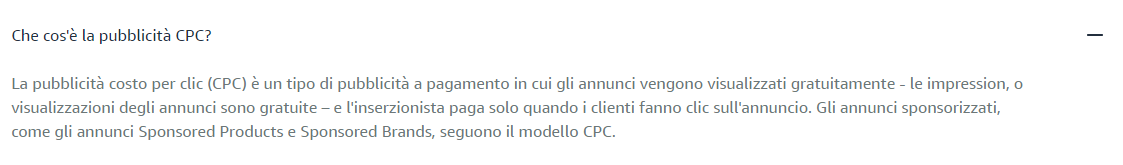 


Pertanto decido di droppare solo quelle che hanno anche impression a 0

In [ ]:
amazon = amazon[~amazon['campaignId'].isin(campaign_to_drop)].reset_index(drop=True)
amazon

Ovviamente ne tovo ancora (Es.280346389415384) perchè devo andare a vedere riga per riga.

Il che dovrebbe essere equivalente a dire che droppo tutte le righe il cui impressionCounter = 0.


In [ ]:
amazon = amazon[amazon['impressionsCounter']!=0].reset_index(drop=True)
amazon

Adesso guardo se a parità di calDate, campaignId ci sono più valori

In [ ]:
amazon.groupby(['calDate', 'campaignId'])['connectionStream'].agg(['count','nunique']).reset_index().sort_values(['count'], ascending=False).head(5)

Ci sono più record a parità di coppia calDate, campaignId, sommo i costi ed i relativi KPI

In [ ]:
amazon = amazon.groupby(['calDate', 'connectionStream', 'campaignId'])['adCost','clicksCounter','impressionsCounter'].sum().reset_index()
amazon.tail(5)

Ci sono discontinuità sulle date?

In [ ]:
pd.date_range(start = amazon['calDate'].min(), end = amazon['calDate'].max()).difference(amazon['calDate'].unique())

Ricontrollo le distrubuzioni perchè ho intenzione di fillare le date mancanti con dei valori di default (tendenzialmente mediana)

In [ ]:
import numpy
columns = ['adCost','clicksCounter','impressionsCounter']
fig, axs = plt.subplots(figsize=(15,18), nrows=len(columns), ncols=2)

for col in columns:
    for perc in [1,25,50,75.90,99]:
        p = numpy.percentile(amazon[col], perc)
        print(f'{perc}th percentile for column {col} is {p}')
    print(f'Avg value for column {col} is {amazon[col].mean()}')
    sns.set_style('whitegrid')
    sns.boxplot(y=col,data=amazon, ax=axs[columns.index(col)][0])
    sns.histplot(data=amazon, x=col, binwidth=round(max(amazon[col])/50,0), ax=axs[columns.index(col)][1], stat='probability', common_norm=False)

Tutti i KPI hanno distribuzioni right skewed, pertanto decido di rimpiazzare i  valori null con il 50 percentile della corrispondente campagna 

In [ ]:
amazon_missing = cf.add_missing_combinations(amazon, date_column='calDate', columns=['connectionStream','campaignId'])
#tmp['calDate']= pd.to_datetime(amazon['calDate']).dt.date

CREO UN DIZIONARIO CON TUTTI I 50 PERCENTILI DI TUTTE LE CAMPAGNE PER CIASCUN KPI

Per ciascuna colonna applico quindi il dizionario sopra

In [ ]:
columns = ['adCost','clicksCounter','impressionsCounter']
d = cf.create_median_dict(amazon, columns)
for col in columns:
    amazon_missing[col] = amazon_missing['campaignId'].map(d[col])
                                                           
amazon_missing.head(5)

Concateno i due Dataframe e controllo che non ci siano date mancanti

In [ ]:
amazon = pd.concat([amazon, amazon_missing], ignore_index=True)
amazon.sort_values(by=['calDate'], inplace=True,ignore_index=True)

print(pd.date_range(start = amazon['calDate'].min(), end = amazon['calDate'].max()).difference(amazon['calDate'].unique()))

In [ ]:
#for conn in amazon['connectionStream'].unique():
#    data_plot = amazon[amazon['connectionStream'] == conn]
#    fig, ax = plt.subplots(1, 1, figsize=(17, 7))
#    sns.boxplot(x='campaignId', y='adCost', data=data_plot, ax=ax).set_title(conn)
#    fig.axes[0].tick_params(axis='x', labelrotation=60)
#    fig.show()